In [1]:
from astropy.io import fits
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import os
import numpy as np
from winterdrp_offline.utils import plot_image, write_image, get_table_from_ldac
from winterdrp_offline.image_operations import median_combine_images, normalize_and_median_combine_images, split_data_into_channels, merge_channels_into_data
from winterdrp_offline.astrometry import get_astrometry_header_from_scamped_file
from winterdrp_offline.sextractor import run_sextractor
from winterdrp_offline.scamp import get_tmass_gaia_catalog_for_image
from winterdrp_offline.photcal import xmatch_img_ref_cats, calculate_zeropoint_outlier_rejection

In [2]:
# Set up the directories
base_dir = Path(os.path.join(os.getenv("HOME"), "data", "calibration_hackathon", "hackathon_datasets"))
print(base_dir)
name = 'ZTF25aadlqhw'
night = '20250220'
boardid = 4

target_dir = base_dir.joinpath(f'{name}/{night}/{boardid}/')

/Users/nlourie/data/calibration_hackathon/hackathon_datasets


In [3]:
raw_list = glob(str(target_dir.joinpath('raw_unpacked/*fits')))
print(f"Found {len(raw_list)} raw files in {target_dir}")

Found 8 raw files in /Users/nlourie/data/calibration_hackathon/hackathon_datasets/ZTF25aadlqhw/20250220/4


Loading WINTERcamera_20250221-072719-143_mef_4_0_0.fits
(1096, 1984)
(16, 16)


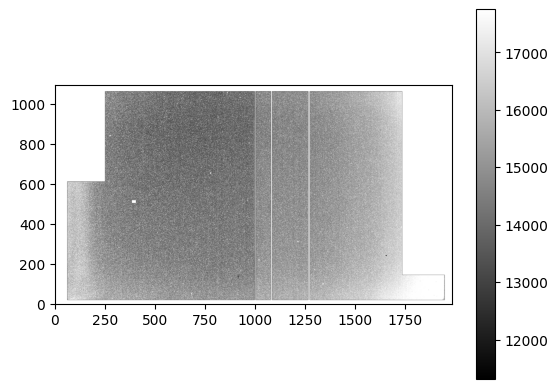

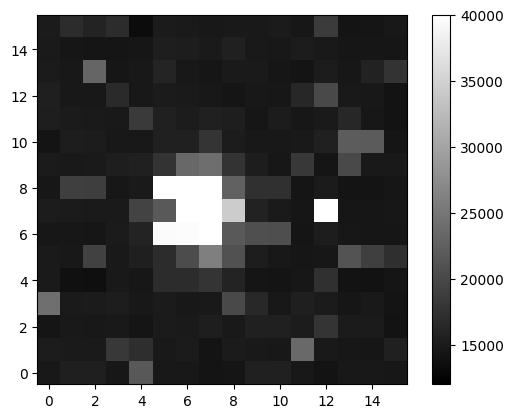

In [ ]:
# Load a raw_unpacked file
img_file = "WINTERcamera_20250221-072719-143_mef_4_0_0.fits"
print(f"Loading {img_file}")
raw_img = fits.getdata(target_dir.joinpath('raw_unpacked', img_file))
from astropy.visualization import ImageNormalize
norm = ImageNormalize(vmin=12000, vmax = 40000)
plot_image(raw_img)

print(raw_img.shape)

roi_center = [312, 1215]
roi_width = 16
roi_height = 16
roi_coords = [roi_center[0] - roi_height//2, roi_center[0] + roi_height//2, roi_center[1] - roi_width//2, roi_center[1] + roi_width//2]
roi = raw_img[roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]
# astropy visualization norm:
norm = ImageNormalize(vmin=min(raw_img), vmax = max(raw_img))
plot_image(roi, norm=norm)
print(roi.shape)

shape of channels: (128, 64)
norm: <astropy.visualization.mpl_normalize.ImageNormalize object at 0x15774f010>


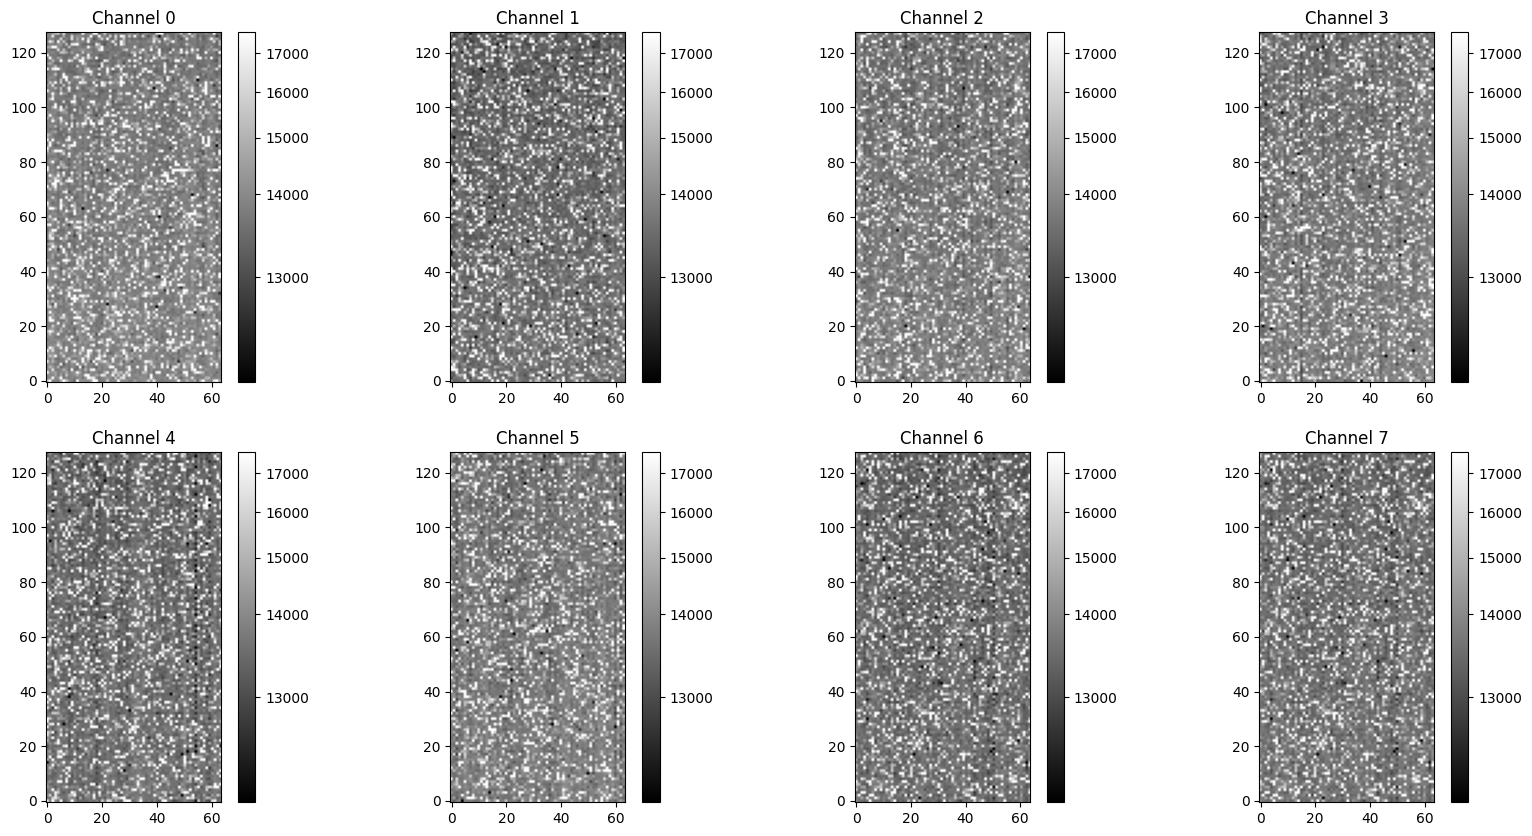

In [12]:
# Split the data up into channels
channels = split_data_into_channels(roi)
print(f"shape of channels: {channels[0].shape}")

# plot all the 8 channels. use the same color scale
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    # if it's the first image, grab the normalization 
    if i==0:
        ax, norm = plot_image(channels[i], ax=ax, return_norm=True, norm = "zscale")
        print(f"norm: {norm}")
    else:
        plot_image(channels[i], ax=ax, norm=norm)
    ax.set_title(f"Channel {i}")
    

plt.show()




In [47]:
# Load the dark file
dark_list = glob(str(target_dir.joinpath('calibration_darks/*fits')))
dark_img = fits.getdata(dark_list[0]) * 120.0 # Note the dark frames are normalized


<Axes: >

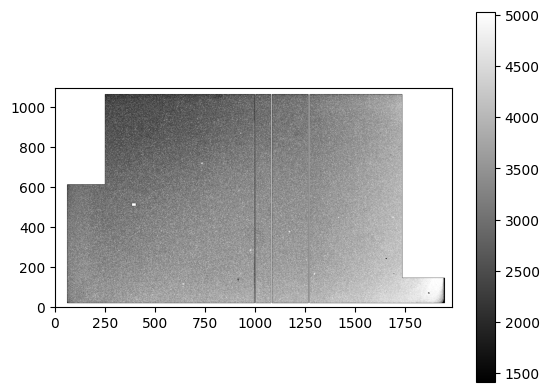

In [48]:
dark_calibrated_image = raw_img - dark_img
plot_image(dark_calibrated_image)

In [49]:
# Load a flat field
flat_list = glob(str(target_dir.joinpath('calibration_flats/*fits')))
flat_img = fits.getdata(flat_list[0])

<Axes: >

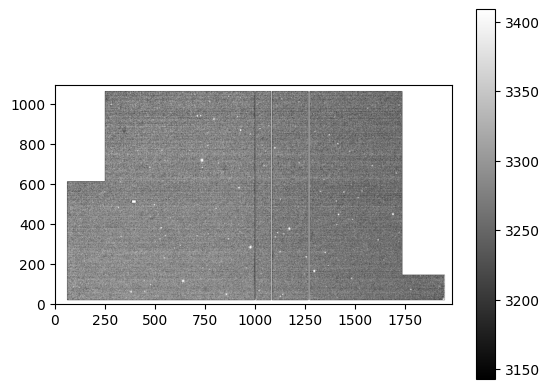

In [50]:
# Flat field the dark calibrated image
flat_calibrated_image = dark_calibrated_image / flat_img
plot_image(flat_calibrated_image)

/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winterdrp_offline/winterdrp_offline/image_operations.py:18: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(data_array, axis=0)


<Axes: >

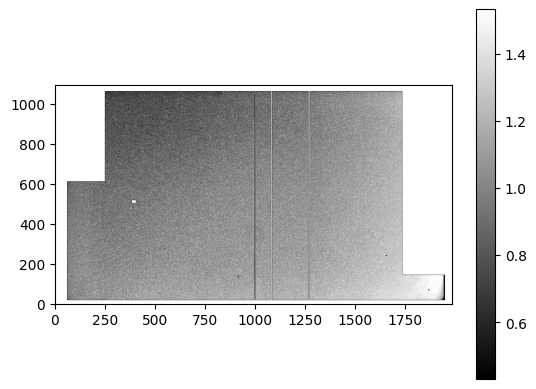

In [51]:
# Load all darkcal images and stack them to make a combined flat
darkcal_list = glob(str(target_dir.joinpath('darkcal/*fits')))
median_flat = median_combine_images(darkcal_list)
median_flat /= np.nanmedian(median_flat)
plot_image(median_flat)

/Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winterdrp_offline/winterdrp_offline/image_operations.py:35: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(data_array, axis=0)


<Axes: >

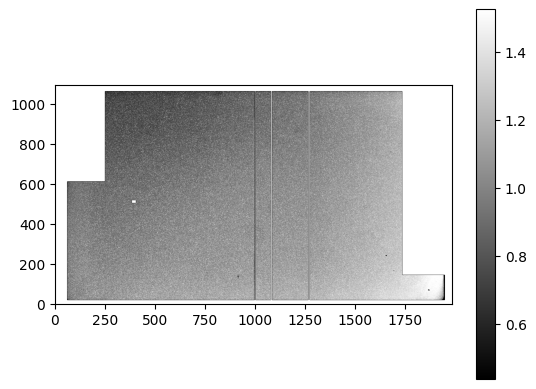

In [52]:
# Make flat by stacking normalized dark images
normalized_median_flat = normalize_and_median_combine_images(darkcal_list)
plot_image(normalized_median_flat)

<Axes: >

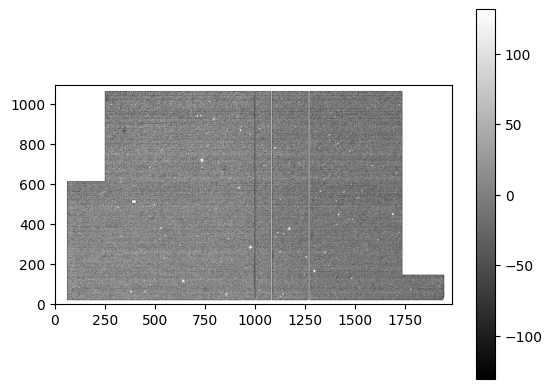

In [53]:
# Load a skysubtracted image
skysub_list = glob(str(target_dir.joinpath('skysub/*fits')))
skysub_img = fits.getdata(skysub_list[0])
plot_image(skysub_img)

In [54]:
# Assign an astrometry header from the post_scamp directory to this file and write it.
scamp_astrometry_header = get_astrometry_header_from_scamped_file(skysub_list[0])
skysub_scamped_filename = skysub_list[0].replace('skysub', 'skysub_scamped')
write_image(image=skysub_img, header=scamp_astrometry_header, filename=skysub_scamped_filename)

In [55]:
# Run sextractor on the skysubtracted image. With regions=True, a regions file
# with all detected sources is written in the target directory.
catname = run_sextractor(skysub_scamped_filename, weightimg=None, regions=True)

Executing command : sex -c /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winterdrp_offline/winterdrp_offline/config/astrom.sex /Users/nlourie/data/calibration_hackathon/hackathon_datasets/ZTF25aadlqhw/20250220/4/skysub_scamped/WINTERcamera_20250221-072926-636_mef_4_0_0.fits -CATALOG_NAME /Users/nlourie/data/calibration_hackathon/hackathon_datasets/ZTF25aadlqhw/20250220/4/skysub_scamped/WINTERcamera_20250221-072926-636_mef_4_0_0.fits.cat -CATALOG_TYPE FITS_LDAC -PARAMETERS_NAME /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winterdrp_offline/winterdrp_offline/config/astrom.param -FILTER_NAME /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winterdrp_offline/winterdrp_offline/config/default.conv -STARNNW_NAME /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winterdrp_offline/winterdrp_offline/config/default.nnw -PIXEL_SCALE 1.12 -DETECT_THRESH 3.0 -ANALYSIS_THRESH 3.0 -SATUR_LEVEL 60000.0 -WEIGHT_TYPE MAP_WEIGHT -WEIGHT_IMAGE /Users/nlourie/data/calibration_hackathon/hackathon_datasets/ZTF25aadlqhw/2025022

In [56]:
image_catalog = get_table_from_ldac(catname)

In [57]:
#filter sources
image_catalog = image_catalog[(image_catalog['MAG_AUTO'] < 99) & (image_catalog['FLAGS']==0) & (image_catalog['FWHM_WORLD']<4.0/3600.0)]


In [58]:
print(f"Found {len(image_catalog)} good sources in the catalog")

Found 1746 good sources in the catalog


In [59]:
ref_cat = get_tmass_gaia_catalog_for_image(skysub_scamped_filename, write_catalog=True, write_regions=True)

SELECT * FROM gaiadr2.gaia_source AS g, gaiadr2.tmass_best_neighbour AS tbest, gaiadr1.tmass_original_valid AS tmass WHERE g.source_id = tbest.source_id AND tbest.tmass_oid = tmass.tmass_oid AND CONTAINS(POINT('ICRS', g.ra, g.dec), CIRCLE('ICRS', 224.8358, 51.5488, 0.2500))=1 AND tmass.j_m > 7.00 AND tmass.j_m < 20.00 AND tbest.number_of_mates=0 AND tbest.number_of_neighbours=1;
INFO: Query finished. [astroquery.utils.tap.core]
Yay


KeyError: 'column "DESIGNATION" does not exist'

In [ ]:
xmatch_cat, xmatch_ref_cat = xmatch_img_ref_cats(image_catalog, ref_cat, xmatch_radius_arcsec=2)
print(f"Found {len(xmatch_cat)} matched sources")

Found 67 matched sources


Text(0.5, 0, '2MASS J mag')

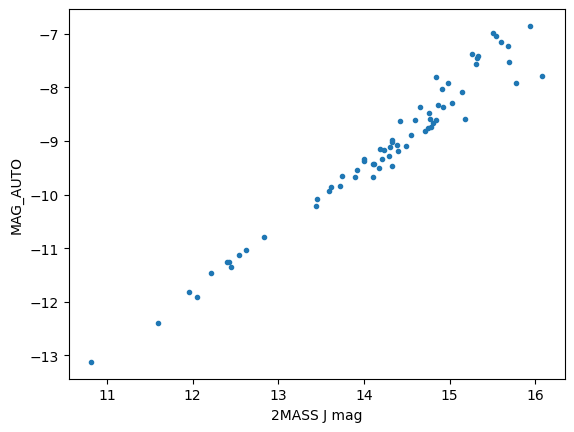

In [ ]:
plt.plot(xmatch_ref_cat['j_m'], xmatch_cat['MAG_AUTO'], '.')
plt.ylabel('MAG_AUTO')
plt.xlabel('2MASS J mag')

In [ ]:
zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(xmatch_cat['MAG_AUTO'], xmatch_ref_cat['j_m'], outlier_rejection_thresholds=[1.5])

Text(0.5, 0, '2MASS J mag')

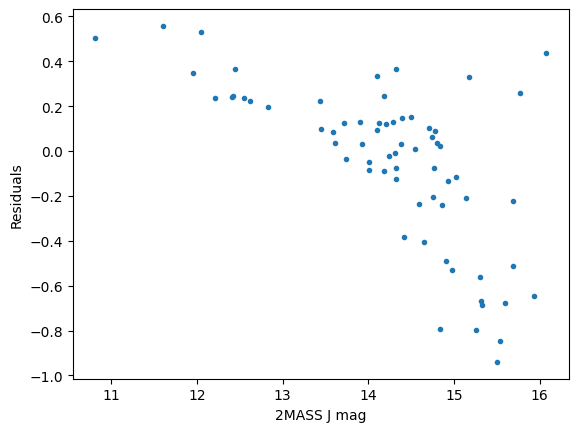

In [ ]:
residuals = xmatch_ref_cat['j_m'] - xmatch_cat['MAG_AUTO'] - zp
plt.plot(xmatch_ref_cat['j_m'], residuals, '.')
plt.ylabel('Residuals')
plt.xlabel('2MASS J mag')

In [ ]:
# Our goal is to improve this plot.